In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(directory['py'])
import techdata_to_tree, sys, ShockFunction
import abatement_EOP_new as abatement
os.chdir(directory['curr'])

The file_gams_py_gdb0.gdx is still active and was not deleted.
The file_gams_py_gdb1.gdx is still active and was not deleted.
The file_gams_py_gdb2.gdx is still active and was not deleted.


*Specify settings:*

In [2]:
name = 'A3'
catalog = "main_catalog"
f = {'tech': directory['data']+"/techdata_" + catalog + ".xlsx",
     'other': directory['data']+"/Othdata_" + catalog + ".xlsx",
     'IOdata':directory['data'] + "/IOdata_" + catalog + ".xlsx"}
s = ['inputdisp','endofpipe','inputprices']
m = ['ID','EOP'] 
e = {'M': 'vars','M_sets': 'sets'} # dictionary used to load emissions data
other_trees = {'ID_Y': {'s': 'Y', 'read_data': {'Y': 'vars'}, 'Q2P': 'Q2P'}} # the key = tree name, s = sheet that specifies tree structure, read_data (if not None) specifies how to load data.

In [3]:
type_f = {'ID_EC': 'CES_norm',
          'ID_CU': 'MNL',
          'ID_TU': 'CET_norm',
          'ID_TX': 'CES',
          'ID_BU': 'linear_out',
          'ID_BX': 'CES',
          'EOP_CU': 'MNL',
          'EOP_TU': 'CET_norm',
          'EOP_TX': 'CES'}

*Set up nesting tree:*

In [4]:
%run ATree.ipynb

## 1: Initialize model

*Set up gams model from tree:*

In [5]:
gm = abatement.abate(nts=nts,tech=tech,use_EOP=True,work_folder=directory['work'],**{'data_folder':directory['gams'],'name': name})
gm.model.settings.catalog = catalog

*Add a couple of extra aliases, and update sets with elements:*

In [6]:
gm.add_aliases([('n','nnnn'),('n','nnnnn')])
gm.model.database.update_all_sets(clean_up=False)
# gm.model.functions = {"std_pdf":"$FUNCTION std_pdf({x}): ((1/(sqrt(2*Pi)))*exp(-(Sqr({x}))/2)) $ENDFUNCTION"}


*Initialise variables at leontief levels, and fill out with simple standard values in potentially missing domains:*

In [7]:
with open(os.getcwd()+'\\conopt_ExtraPivot.opt',"r") as file:
    kwargs_mi = {'opt_file': file.read()}

In [8]:
gm.initialize_variables_leontief()
gm.initialize_variables(**{'check_variables': True})

In [9]:
if catalog == "categoryexperiment_ID":
    gm.setstate("ID")

In [10]:
#gm.model.database['testminobj'] = 0;

## 2: Solve model


*Set up baseline model and solve:*

In [11]:
gm.write_and_run(name='baseline')
db0 = gm.model_instances['baseline'].out_db


*Read back solution to main db:*

In [12]:
gm.model.database.merge_dbs(gm.model.database,db0,'second')

*Turn exogenous parameters into place*

In [13]:
db_star = DataBase.GPM_database(**{'name': 'db_star'})
sigma_star = gm.get("sigma").copy()
eta_star = gm.get("eta").copy()
mu_star = gm.get("mu").copy()
if "EOP" in gm.state:
    sigmaG_star = gm.get("sigmaG").copy()

In [14]:
eta_star[:] = -5
sigma_star[gm.get("kno_ID_CU")] = 10
sigma_star[gm.get("kno_ID_BX")] = 0.3
# sigma_star["Y"] = 0.5

mu_star[gm.get("map_ID_CU")] = 1.0

if "EOP" in gm.state:
    mu_star[gm.get("map_EOP_CU")] = 1.0
    sigma_star[gm.get("kno_EOP_CU")] = 10
    sigmaG_star[:] = 0.1
    db_star["sigmaG"] = sigmaG_star
    
db_star["sigma"] = sigma_star
db_star["eta"] = eta_star
db_star["mu"] = mu_star

In [15]:
name='v0'
gm.write_and_run(name=name, add_checkpoint=name)
gm.checkpoints['v1'] = gm.model_instances[name].ws.add_checkpoint()
print(gm.model_instances[name].solve_sneakily(db_star=db_star,from_cp = True, cp_init = gm.checkpoints[name], options_run={'checkpoint': gm.checkpoints['v1']}, kwargs_shock={"n_steps":100}))
db1 = gm.model_instances[name].out_db
gm.model.database.merge_dbs(gm.model.database,db1,'second')

{'Modelstat': 16.0, 'Solvestat': 1.0}


*Change to calibration state and resolve:*

In [16]:
gm.reset_settings()
gm.setstate('EOP_calibrate',init=False)

In [17]:
gm.write_and_run(name='EOP_calibrate',kwargs_init={'check_variables':True},overwrite=True)
db0 = gm.model_instances['EOP_calibrate'].out_db
gm.model.database.merge_dbs(gm.model.database,db0,"second")

In [ ]:
gm.export(name=catalog)

### Make this work:

In [18]:
gm.model_instances["EOP_calibrate"].modelstat

2.0

In [20]:
db = gm.add_calib_data(f["IOdata"], currapp=False)
gm.model.database.merge_dbs(gm.model.database,db,"second")
# # db = DataBase.GPM_database()
# # qD = gm.get("qD").copy()

# # qD[gm.get("bra_ID_BX")] = qD[gm.get("bra_ID_BX")] + 0.25
# # qD["Y_oil"] = qD["Y_oil"] - 1
# # db["qD"] = qD

# # DataBase.GPM_database.merge_dbs(gm.model.database, db, "second")

In [21]:
#gm.calibrate_sneaky(db, state_names={"baseline":"EOP", "calibrate":"EOP_calibrate"}, **{'n_steps':100})

In [22]:
gm.write_and_run(name='EOP_calibrateIO',kwargs_init={'check_variables':True},overwrite=True)
db = gm.model_instances['EOP_calibrateIO'].out_db

In [25]:
gm.model_instances["EOP_calibrateIO"].modelstat

5.0

In [22]:
#gm.model_instances["EOP_calibrateIO"]

5.0

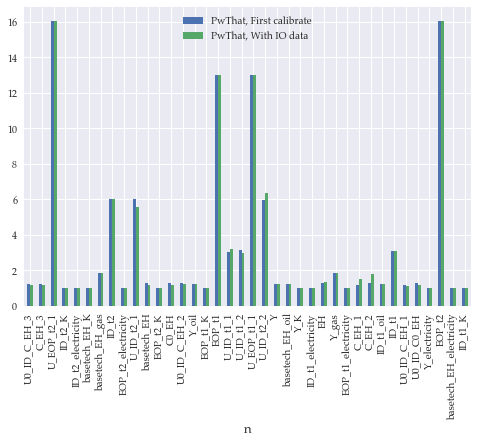

In [25]:
var = 'PwThat'
compare_plots(db0,db,var)

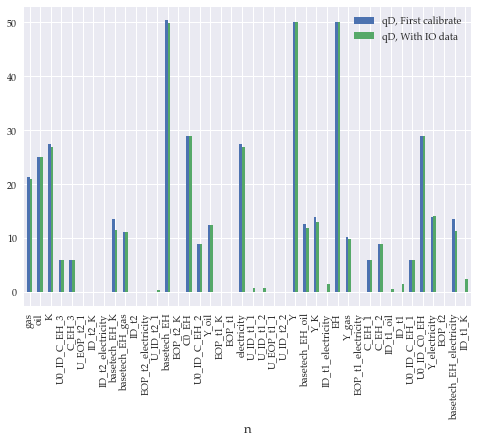

In [26]:
var = 'qD'
compare_plots(db0,db,var)